In [151]:
# Import dependencies
import os, sys
from PIL import Image
from IPython.display import display
from IPython.display import Image as _Imgdis
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import psutil 

# import keras 

In [174]:
def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)
    ax.xaxis.set_ticklabels(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],fontsize=10)
    ax.yaxis.set_ticklabels(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],fontsize=10)

# Data processing and downsizing images

In [153]:
labels = np.array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
X = []
y = []
samples = 15000
pixels = 50

for label in labels:
    folder = './Rice_Image_Dataset/' + label + '/'
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for i in range(samples):
        img = Image.open(folder + "/" + files[i])
        # img_gray = img.convert('L')
        img.thumbnail((pixels, pixels)) # resize to 50 x 50
        img_array = np.asarray(img)
        X.append(img_array)
        y.append(label)

X = np.asarray(X)
Xr = X.reshape(5*samples, pixels*pixels*3)
y = np.array(y)

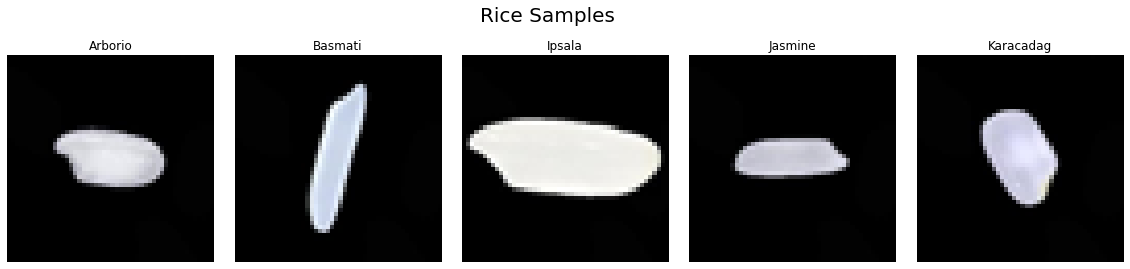

In [168]:
# Show rice
def show_rice(Xr, y, cols=5, title=None):
    fig, axs = plt.subplots(1, cols, figsize=(20,5))
    plt.axis('off')
    for i in range(len(labels)):
        rice = labels[i]
        idx = np.argwhere(y == rice)[0]
        im = Xr[idx].reshape(pixels, pixels, 3)
        axs[i].set_title(f'{rice}')
        axs[i].imshow(im)
        axs[i].axis('off')
    # change the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=-0.3)
    if title is not None:
        fig.suptitle(title,fontsize=20)
        fig.subplots_adjust(top=0.99)
    
show_rice(Xr, y, title='Rice Samples')

# Split dataset

In [156]:
# Split dataset
X_train, X_remaining, y_train, y_remaining = train_test_split(Xr, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state = 42)

# PCA

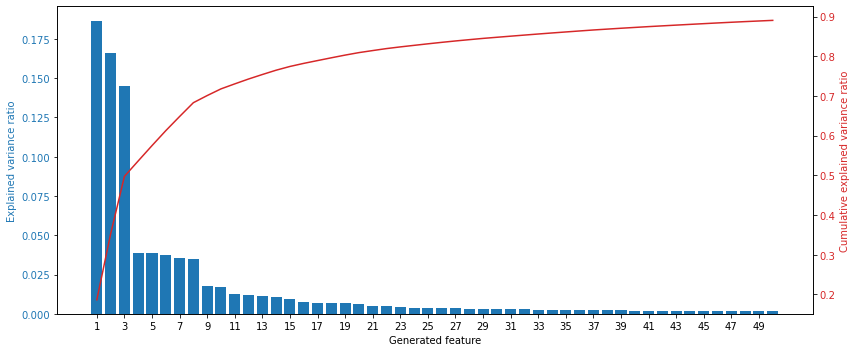

In [160]:
# Fit PCA 
N = 50
pca = PCA(n_components=N) 
X_train_reduced = pca.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()

In [108]:
# N = 50
# pca.set_params(n_components=N)
# X_train_reduced = pca.fit_transform(X_train)

# Logistic Regression

### Hyperparamter tuning: Adjusting regularization strength for logistic regression

In [166]:
training_accuracy_list = []
validation_accuracy_list = []
C_list = []

# C_values = np.linspace(0.01, 10, 10)
C_values = np.logspace(-3, 4, 8)

for i in C_values:
    log_reg = LogisticRegression(solver='saga', max_iter = 500, C=i) 
    log_reg.fit(X_train_reduced, y_train)
    y_train_pred = log_reg.predict(X_train_reduced)
    y_val_pred = log_reg.predict(X_val_reduced)
    training_accuracy = accuracy_score(y_train, y_train_pred) # compute the accuracy score
    validation_accuracy = accuracy_score(y_val, y_val_pred)
    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    C_list.append(i)

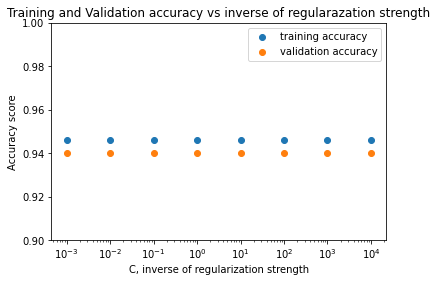

In [112]:
# Plot C vs accuracy
plt.scatter(C_list, training_accuracy_list, label="training accuracy")
plt.scatter(C_list, validation_accuracy_list, label="validation accuracy")
plt.xlabel("C, inverse of regularization strength")
plt.ylabel("Accuracy score")
plt.title("Training and Validation accuracy vs inverse of regularazation strength")
ax = plt.gca()

ax.set_xscale('log')
# ax.set_xlim([xmin, xmax])
plt.legend()
ax.set_ylim([0.9, 1])
plt.show()

In [150]:
print(training_accuracy_list)
print(validation_accuracy_list)

[0.9461714285714286, 0.9461904761904761, 0.9461714285714286, 0.9461904761904761, 0.9461714285714286, 0.9461904761904761, 0.9461904761904761, 0.9461904761904761]
[0.9399111111111111, 0.9398222222222222, 0.9399111111111111, 0.9398222222222222, 0.9398222222222222, 0.9399111111111111, 0.9399111111111111, 0.9399111111111111]


### Training on combined training and validation set, testing on test set

In [176]:
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

N = 50
pca = PCA(n_components=N) 
X_combined_reduced = pca.fit_transform(X_combined)

# print(len(X_train[:,0]))
# print(len(X_combined[:,0]))

log_reg = LogisticRegression(solver='saga', max_iter = 500) 
log_reg.fit(X_combined_reduced, y_combined)

In [164]:
# Testing
X_test_reduced = pca.transform(X_test)
y_test_pred = log_reg.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test prediction accuracy: {100*test_accuracy:.2f}%")

Test prediction accuracy: 95.21%


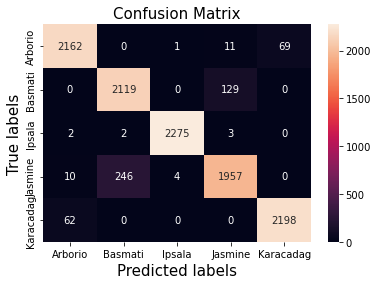

In [175]:
generate_confusion_matrix(y_test, y_test_pred)